In [4]:
!pip install torchmetrics

In [5]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

# %cd /content/gdrive/MyDrive/Colab Notebooks/university

In [20]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2021-12-21 20:19:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  21.3MB/s    in 32s     

2021-12-21 20:19:43 (20.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [6]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchmetrics import Accuracy

from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import seaborn as sns
from matplotlib import pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
data_df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
data_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
data_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [9]:
mapper = {cat: n for n, cat in enumerate(data_df.subject.unique())}

data_df['category'] = data_df.subject.map(mapper)
data_df = shuffle(data_df)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_df.text.tolist(), data_df.category.tolist(), test_size=0.2)

In [11]:
word2freq = {}
train_lengths = []

for text in tqdm(X_train, desc='Processing train'):
    
    words = wordpunct_tokenize(text.lower())
    train_lengths.append(len(words))
    
    for word in words:
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

for text in tqdm(X_test, desc='Processing test'):
    words = wordpunct_tokenize(text.lower())
    
    for word in words:
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

max_len = max(train_lengths)

Processing train:   0%|          | 0/18784 [00:00<?, ?it/s]

Processing test:   0%|          | 0/4697 [00:00<?, ?it/s]

In [12]:
max_len

9364

(Эксперименты показали, что это очень много и памяти не хватает - обрежем до 500)

In [37]:
max_len = 500

In [38]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('./wiki-news-300d-1M.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec:   0%|          | 0/999994 [00:00<?, ?it/s]

In [39]:
vectors.shape[0] == len(word2index)

True

In [40]:
class NewsData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, max_len, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.max_len = max_len
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text, word2index):
                
        words = wordpunct_tokenize(text.lower())
        words = [token for token in words if token.isalpha()]
        #words = re.findall('[a-яА-ЯеЁ]+', text.lower())
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            
            words = self.process_text(text, self.word2index)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить

        if len(sequence)< self.max_len:
          add_pad = self.max_len - len(sequence)
          return sequence+[self.pad_index]*add_pad
        else:
          return sequence[:self.max_len]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()        
        y = self.y_data[idx]
        
        return x, y

In [106]:
train_dataset = NewsData(X_train, y_train, word2index, max_len)
train_iterator = DataLoader(train_dataset, batch_size=128)

test_dataset = NewsData(X_test, y_test, word2index, max_len)
test_iterator = DataLoader(test_dataset, batch_size=128)

Loading data:   0%|          | 0/18784 [00:00<?, ?it/s]

Loading data:   0%|          | 0/4697 [00:00<?, ?it/s]

In [107]:
for x, y in train_iterator:
    break

In [108]:
x

tensor([[   94,    87,   122,  ...,     0,     0,     0],
        [    7,     2,  6682,  ...,   212,   118,  1624],
        [ 5795,  3343,   477,  ...,     0,     0,     0],
        ...,
        [    8, 35399,  2323,  ...,   917,    91,     4],
        [   87,   500,  1392,  ...,     0,     0,     0],
        [   77,    30,    97,  ...,     0,     0,     0]])

In [109]:
y

tensor([3, 0, 0, 3, 0, 0, 0, 1, 1, 4, 0, 3, 1, 5, 2, 1, 0, 0, 1, 1, 3, 1, 3, 3,
        1, 4, 1, 0, 3, 1, 0, 3, 0, 0, 3, 1, 0, 1, 3, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        5, 2, 3, 3, 3, 3, 0, 0, 0, 3, 1, 3, 3, 3, 0, 0, 3, 0, 4, 0, 3, 1, 0, 1,
        1, 3, 1, 1, 1, 2, 1, 1, 3, 2, 1, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 5, 2, 3, 0, 3, 0, 4, 1, 0, 1, 4, 0, 0, 1, 3, 1, 1, 3, 3,
        1, 1, 3, 1, 0, 0, 1, 1])

In [104]:
class C_LSTM(nn.Module):
    
    def __init__(self, matrix_w, params):
        super().__init__()

        self.add_conv_dropout = params['add_conv_dropout']
        self.add_lstm_dropout = params['add_lstm_dropout']
        self.add_conv2 = params['add_conv2']
        if self.add_conv2:
            self.lstm_input = 2*params['filter_num']
        else:
            self.lstm_input = params['filter_num']

        self.embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w), freeze=False)

        self.conv2 = nn.Conv1d(in_channels=matrix_w.shape[1], out_channels=params['filter_num'], kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=matrix_w.shape[1], out_channels=params['filter_num'], kernel_size=3)

        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=self.lstm_input, hidden_size=params['lstm_dim'], num_layers=1, batch_first=True)

        self.linear = nn.Linear(in_features=params['lstm_dim'], out_features=6)
        self.dropout = nn.Dropout(p=0.5)

    
    def forward(self, text):
      embedded = self.relu(self.embedding(text))
      embedded = embedded.transpose(1,2)

      if self.add_conv_dropout:
        embedded = self.dropout(embedded)

      #  feature_map.shape = batch_size*out_channels*seq_len
      feature_map = self.relu(self.conv3(embedded))

      if self.add_conv2:
        feature_map_2 = self.relu(self.conv2(embedded))
        max_conv_len = min(feature_map.shape[2], feature_map_2.shape[2])
        feature_map = torch.cat((feature_map[ : , : , :max_conv_len-1], feature_map_2[ : , : , :max_conv_len-1]), dim=1)

      #  out_channels -> number of x features (input_size)
      #  seq_len -> seq_len

      _, (h_t, c_t) = self.lstm(feature_map.transpose(1,2))

      if self.add_lstm_dropout:
        h_t = self.dropout(h_t)
      
      output = self.linear(h_t.squeeze())

      return output
      

In [93]:
def run_train_val(train_loader, val_loader, model, optimizer, criterion, n_epochs, device):
  losses_train = []

  losses_eval = []
  acc_eval = []

  for epoch in range(n_epochs):
      progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {} train'.format(epoch + 1))
      epoch_loss = 0
      model.train()  

      for i, (texts, ys) in enumerate(train_loader): 
          optimizer.zero_grad() 

          texts = texts.to(device)
          ys = ys.to(device)
          
          preds = model(texts)
              
          loss = criterion(preds.to(device), ys)
          loss.backward()   
          optimizer.step() 
          epoch_loss += loss.item() 

          if not (i + 1) % int(len(train_loader)/5):
              progress_bar.set_postfix(train_loss=epoch_loss/(i+1))

          progress_bar.update(len(ys))
      
      progress_bar.close()
      losses_train.append(epoch_loss / len(train_loader))

      progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {} test evaluating'.format(epoch + 1))
      epoch_loss = 0
      metric = Accuracy()
      model.eval() 

      with torch.no_grad():
          for i, (texts, ys) in enumerate(val_loader):   
              texts = texts.to(device)
          
              preds = model(texts)
              
              loss = criterion(preds.cpu(), ys)     
              epoch_loss += loss.item()
              batch_metric = metric(np.argmax(preds.cpu(), axis=1), ys)

              if not (i + 1) % int(len(val_loader)/5):
                progress_bar.set_postfix(val_loss=epoch_loss/(i+1), val_acc=batch_metric)

              progress_bar.update(len(ys))

      losses_eval.append(epoch_loss / len(val_loader))
      epoch_acc = metric.compute()
      acc_eval.append(epoch_acc)

      print('Epoch accuracy: ', epoch_acc)
    
  return losses_train, losses_eval, acc_eval      

In [79]:
def plot_losses(losses_train, losses_eval, acc_eval):
  fig, ax = plt.subplots(2, figsize=(5, 10))
  ax[0].plot(losses_train)
  ax[0].plot(losses_eval)
  ax[0].set_title('CE loss value')
  ax[0].set_ylabel('CE loss')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'val'], loc='upper right')
 
  ax[1].plot(acc_eval)
  ax[1].set_title('Accuracy value')
  ax[1].set_ylabel('Accuracy value')
  ax[1].set_xlabel('epoch')
   
  plt.show()

In [80]:
def run_experiment(params):
  model = C_LSTM(vectors, params)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(params=model.parameters(), weight_decay=params['weight_decay'])

  model = model.to(device)
  criterion = criterion.to(device)

  losses_train, losses_eval, acc_eval = run_train_val(train_iterator, test_iterator, model, optimizer, criterion, params['n_epochs'], device)
  plot_losses(losses_train, losses_eval, acc_eval)

Прогоним на дефолтных параметрах - без дропаутов, с одним слоем свертки и размерностями 150

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5022)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4722)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5593)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5978)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6057)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6172)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6249)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6221)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6230)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5944)


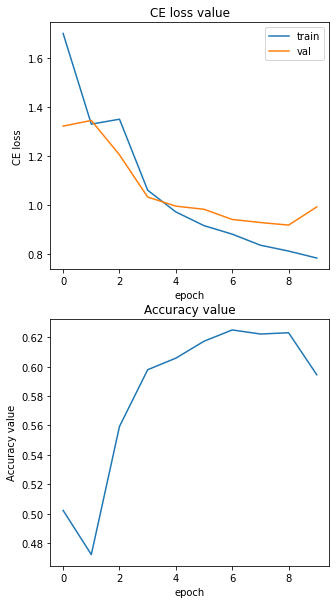

In [81]:
params = {}
params['add_conv_dropout'] = False
params['add_lstm_dropout'] = False
params['add_conv2'] = False
params['filter_num'] = 150
params['lstm_dim'] = 150
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

Неплохо, добавим один дропаут

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5069)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5114)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5103)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5108)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5271)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5912)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5961)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5957)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5616)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5753)


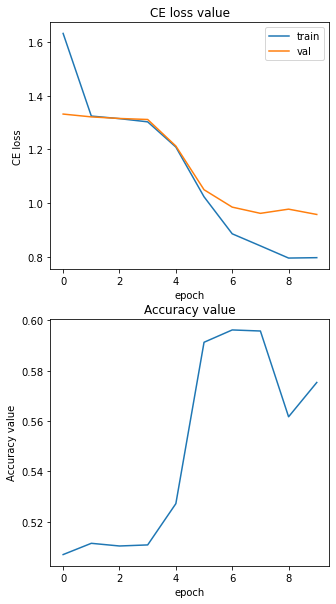

In [82]:
params = {}
params['add_conv_dropout'] = True
params['add_lstm_dropout'] = False
params['add_conv2'] = False
params['filter_num'] = 150
params['lstm_dim'] = 150
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

И другой (в статье вроде сказано, что они не используют два одновременно - видимо, тогда теряется слишком много информации)

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5022)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5020)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5044)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5925)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5882)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5966)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6070)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6166)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6181)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6391)


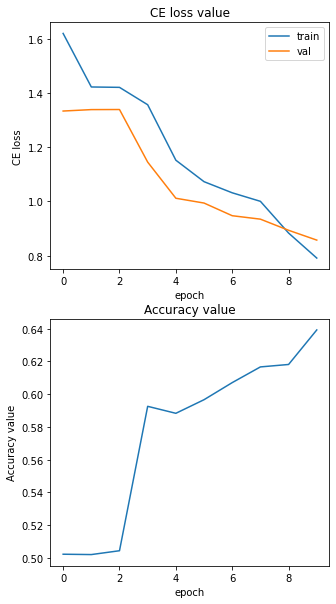

In [118]:
params = {}
params['add_conv_dropout'] = False
params['add_lstm_dropout'] = True
params['add_conv2'] = False
params['filter_num'] = 150
params['lstm_dim'] = 150
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

Дропаут для ЛСТМ помог больше всех. Попробуем увеличить размерности выходов сверток и ЛСТМ (без дропаута)

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4113)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3651)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4007)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5748)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5914)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5970)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6021)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6149)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6072)


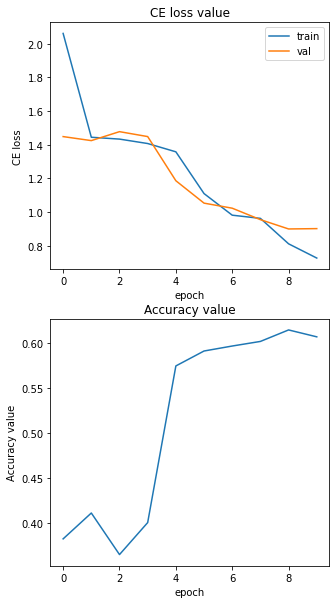

In [85]:
params = {}
params['add_conv_dropout'] = False
params['add_lstm_dropout'] = False
params['add_conv2'] = False
params['filter_num'] = 300
params['lstm_dim'] = 300
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

Особо ничего не поменялось, попробуем добавить L2-регуляризацию

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4978)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4986)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.2951)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4956)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5001)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5042)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4961)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5042)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4861)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4703)


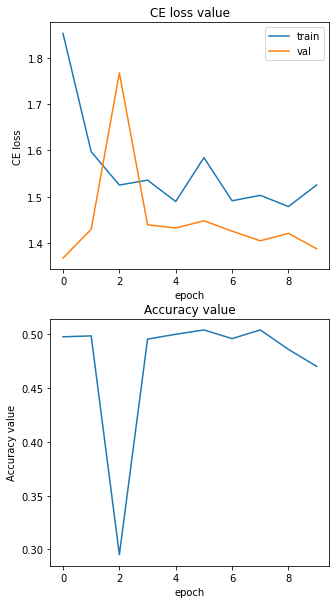

In [119]:
params = {}
params['add_conv_dropout'] = False
params['add_lstm_dropout'] = False
params['add_conv2'] = False
params['filter_num'] = 300
params['lstm_dim'] = 300
params['weight_decay'] = 0.001
params['n_epochs'] = 10

run_experiment(params)

Модель как-то очень нестабильно обучается и теряет в качестве. Вернем дропаут и попробуем добавить еще один сверточный слой с другим окном

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3311)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.4011)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6044)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6068)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6074)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6072)


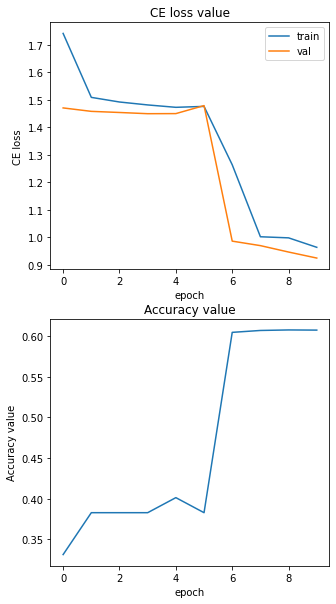

In [110]:
params = {}
params['add_conv_dropout'] = True
params['add_lstm_dropout'] = True
params['add_conv2'] = True
params['filter_num'] = 300
params['lstm_dim'] = 300
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

Вариант с дропаутом без второй свертки все еще лучше. Попробуем сразу два вида регуляризации

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.1901)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3128)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3191)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3883)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3994)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3860)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.3826)


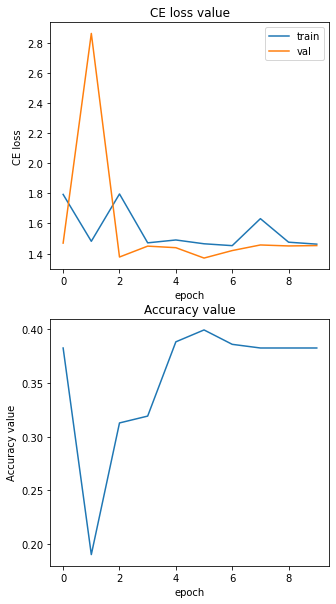

In [120]:
params = {}
params['add_conv_dropout'] = True
params['add_lstm_dropout'] = True
params['add_conv2'] = False
params['filter_num'] = 300
params['lstm_dim'] = 300
params['weight_decay'] = 0.001
params['n_epochs'] = 10

run_experiment(params)

Вообще ниче не обучается нормально и очень низкое качество. Вернемся к лучшей модели, но с увеличенным количеством выходов сверток и лстм

Epoch 1 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 1 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.5020)


Epoch 2 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6063)


Epoch 3 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6138)


Epoch 4 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6232)


Epoch 5 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6208)


Epoch 6 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6234)


Epoch 7 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6236)


Epoch 8 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6247)


Epoch 9 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6257)


Epoch 10 train:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10 test evaluating:   0%|          | 0/4697 [00:00<?, ?it/s]

Epoch accuracy:  tensor(0.6281)


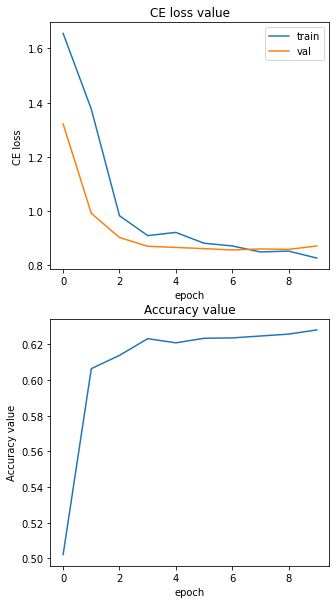

In [123]:
params = {}
params['add_conv_dropout'] = False
params['add_lstm_dropout'] = True
params['add_conv2'] = False
params['filter_num'] = 300
params['lstm_dim'] = 300
params['weight_decay'] = 0
params['n_epochs'] = 10

run_experiment(params)

Лучшее не превосходит

### Выводы и возможные улучшения:
- во-первых, сам тип данных очень странный, непонятное разделение между классами какое-то, этим и объясняется плохое качество в общем и целом
- L2-регуляризация негативно сказывается на процессе обучения, дропауты же помогают больше всего (после ЛСТМ)
- как и у авторов статьи, у нас лучше всего сработал вариант только с одним сверточным слоем
- лучшим вариантом оказывается архитектура с 150 выходами у лстм и у сверток, увеличение их количества не приводит к лучшим результатам